# Overview
This notebook demonstrates how to use DataShader to display large datasets inside a plotly `FigureWidget`. Change callbacks are used to recompute the datashader image whenever the axis range or figure size changes

## Imports

In [2]:
from plotly.graph_objs import FigureWidget

# core
import io
import base64 
import time

# pandas
import pandas as pd

# numpy
import numpy as np

# scikit learn
from sklearn import datasets

# datashader
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import inferno

## Generate dataset
We will create a large dataset by duplicating the Iris dataset many times with random noise

In [3]:
num_copies = 7000 # 1,050,000 rows

iris_data = datasets.load_iris()
feature_names = [name.replace(' (cm)', '').replace(' ', '_') for name in iris_data.feature_names]
iris_df_orig = pd.DataFrame(iris_data.data, columns=feature_names)
target_orig = iris_data.target + 1

# frame of features
iris_df = pd.concat(
    np.random.normal(scale=0.2, size=iris_df_orig.shape) + iris_df_orig for i in range(num_copies)
).reset_index(drop=True)

# array of targets
target = [t for i in range(num_copies) for t in target_orig]

# dataframe that includes target as categorical
iris_target_df = pd.concat([iris_df, pd.Series(target, name='target', dtype='category')], axis=1)

iris_df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06
mean,5.843382e+00,3.054099e+00,3.758985e+00,1.198534e+00
std,8.491915e-01,4.758402e-01,1.769888e+00,7.867075e-01
min,3.583848e+00,1.255490e+00,1.606269e-01,-8.319589e-01
25%,5.156951e+00,2.740879e+00,1.636863e+00,3.922330e-01
50%,5.801421e+00,3.033527e+00,4.307930e+00,1.315497e+00
75%,6.443072e+00,3.346467e+00,5.143558e+00,1.827864e+00
max,8.645840e+00,5.190408e+00,7.688792e+00,3.313914e+00


## Define DataShader image generation function
Define a function that inputs an x/y ranges and the plot width/height and generates a DataShader image of the dataset.  The image will be returned as a PIL image object

In [4]:
def gen_ds_image(x_range, y_range, plot_width, plot_height):
    if x_range is None or y_range is None or plot_width is None or plot_height is None:
        return None
    
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=plot_height, plot_width=plot_width)
    agg_scatter = cvs.points(iris_target_df, 
                         'sepal_length', 'sepal_width', 
                          ds.count_cat('target'))
    img = tf.shade(agg_scatter)
    img = tf.dynspread(img, threshold=0.95, max_px=5, shape='circle')
    
    return img.to_pil()

## Define initial ranges and plot size

In [5]:
x_range=[3, 10]
y_range=[0, 6]
plot_height=500
plot_width=700

In [6]:
# Test image generation function and display the PIL image
initial_img = gen_ds_image(x_range, y_range, plot_width, plot_height)

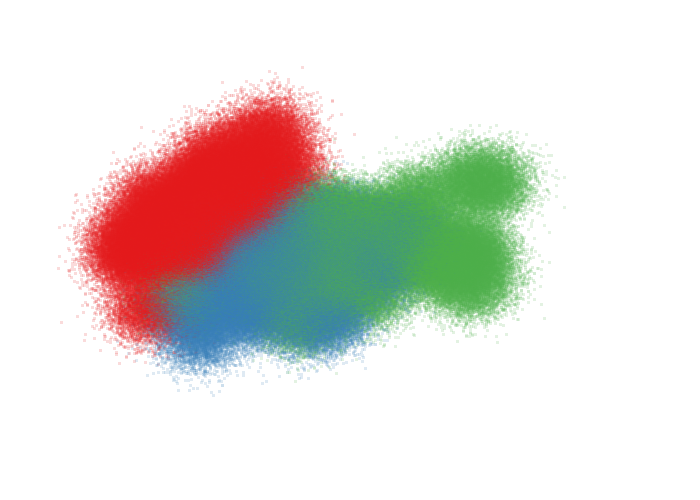

In [7]:
initial_img

# Create FigureWidget with background image

In [8]:
f = FigureWidget(data=[{'x': x_range, 
                        'y': y_range, 
                        'mode': 'markers',
                        'marker': {'opacity': 0}}], # invisible trace to init axes and to support autoresize
                 layout={'width': plot_width, 'height': plot_height})
f

FigureWidget({
    'data': [{'marker': {'opacity': 0},
              'mode': 'markers',
              'type': …

In [9]:
# Set background image
f.layout.images = [dict(
    source = initial_img,  # plotly now performs auto conversion of PIL image to png data URI
    xref = "x",
    yref = "y",
    x = x_range[0],
    y = y_range[1],
    sizex = x_range[1] - x_range[0],
    sizey = y_range[1] - y_range[0],
    sizing = "stretch",
    layer = "below")]

## Install change callback to update image on zoom/resize

In [10]:
def update_ds_image(layout, x_range, y_range, plot_width, plot_height):
    img = f.layout.images[0]
    
    # Update with batch_update so all updates happen simultaneously
    with f.batch_update():
        img.x = x_range[0]
        img.y = y_range[1]
        img.sizex = x_range[1] - x_range[0]
        img.sizey = y_range[1] - y_range[0]
        img.source = gen_ds_image(x_range, y_range, plot_width, plot_height)

# Install callback to run exactly once if one or more of the following properties changes
#  - xaxis range
#  - yaxis range
#  - figure width
#  - figure height
f.layout.on_change(update_ds_image, 'xaxis.range', 'yaxis.range', 'width', 'height')

## Image updates on drag zoom

In [11]:
f.layout.dragmode = 'zoom'
f

FigureWidget({
    'data': [{'marker': {'opacity': 0},
              'mode': 'markers',
              'type': …